<a href="https://colab.research.google.com/github/egyan175/F1-Strategy-Quantitative-Investigation/blob/main/01_Tyre_Degradation_Physics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 01: Tyre Degradation Physics

**Building a physics-based F1 car model with tyre wear and fuel load effects**

---

## Objectives

1. Implement a `Car` class that simulates lap-by-lap performance
2. Model tyre degradation as a linear function of tyre age
3. Model fuel load effects on lap time (lighter car = faster)
4. Visualize the competition between tyre wear (slowing down) and fuel burn (speeding up)

---

## Physics Foundation (Milliken & Milliken)

### Tyre Degradation Model

As tyres wear, the contact patch effectiveness decreases, reducing grip and cornering speed:

$$\Delta T_{tyre} = \text{TyreAge} \times \text{DegradationRate}$$

**Typical values:** 0.025-0.070 s/lap depending on compound

### Fuel Load Effect

Heavier cars are slower due to increased tyre loading and inertia:

$$\Delta T_{fuel} = \text{FuelLoad} \times 0.035 \text{ s/kg}$$

**Race start:** ~110 kg fuel → ~3.85s penalty vs empty
**Race end:** ~0 kg fuel → 0s penalty

### Net Effect

Early in the race, fuel burn dominates (lap times improve).  
Later, tyre degradation dominates (lap times worsen).  
The crossover point depends on compound and conditions.

---

## Notebook Dependencies

- `numpy` — Numerical operations
- `pandas` — Data handling
- `matplotlib` — Visualization
- `fastf1` — F1 telemetry (imported but not heavily used here)

In [1]:
!pip install fastf1

import fastf1 as fa
from fastf1 import plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.0/123.0 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.8 MB/s eta 0:00:00
  Created wheel for msgpack: filename=msgpack-1.0.2-cp312-cp312-linux_x86_64.whl size=15820 sha256=9f1beefd8a1273e2a26e1158a547171ba5fd819a2aa67fb49f6f14c2597b7eab
  Stored in directory: /root/.cache/pip/wheels/67/a6/40/eda0983e595bbf3841af96dbff2340be72dfac96796fc3d578
Successfully built msgpack
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.1.2
    Uninstalling msgpack-1.1.2:
      Successfully uninstalled msgpack-1.1.2


---

## Car Class Implementation

This class models a single F1 car with:
- Driver and team identification
- Position and lap tracking
- Tyre compound and age state
- Fuel load that depletes each lap
- Physics-based lap time calculation

**Key method:** `simulate_lap()` computes lap time from base pace + tyre penalty + fuel penalty

In [2]:
# CAR CLASS - F1 PHYSICS MODEL

"""
Implements vehicle dynamics concepts and physics from Milliken & Milliken (1995):
- Tyre degradation (wear reduces grip)
- Fuel load effects (tyre-load sensitivity)
- Base pace (inherent car/driver performance)
"""

class Car:
    """
    Single F1 car with physics-based lap time simulation.

    1. Tyre Degradation:
       - Wear reduces contact patch effectiveness
       - Linear model: t = Tyre_age × degradation_rate

    2. Fuel Load Effect:
       - Load sensitivity

       - Combined: ~0.035 s/lap per kg
    """

    def __init__(self, driver_code, team, grid_position):
        """
        initialise F1 car.

        Args:
            driver_code (str): Three-letter driver code
            team (str): Team name
            grid_position (int):
        """

        self.driver = driver_code
        self.team = team


        self.position = grid_position


        self.current_lap = 0


        self.total_time = 0.0



        self.Tyre_compound = 'MEDIUM'


        self.Tyre_age = 0

        self.fuel_load = 110.0  # kg


        self.base_pace = None

        # Tyre degradation rate: seconds per lap penalty

        # Typical: 0.030 s/lap for medium compound
        self.Tyre_degradation_rate = None


        self.lap_times = []


    def simulate_lap(self, lap_number):
        """
        Simulate one racing lap with physics.


        Calculates lap time based on:
        1. Base pace (car/driver inherent speed)
        2. Tyre degradation (wear penalty)
        3. Fuel load (weight penalty)

        Args:
            lap_number (int): Current lap number (1-70)

        Returns:
            float: Lap time in seconds

        Raises:
            ValueError: If base_pace not set
        """


        if self.base_pace is None:
            raise ValueError(
                f"Car {self.driver} has no base_pace set"
                f" Must set base_pace before simulating."
            )



        lap_time = self.base_pace



        # PHYSICS MODEL 1: Tyre DEGRADATION


        if self.Tyre_degradation_rate is not None:
            # Calculate Tyre wear penalty
            Tyre_penalty = self.Tyre_age * self.Tyre_degradation_rate

            # Add to lap time (makes car slower)
            lap_time += Tyre_penalty





        FUEL_EFFECT_PER_KG = 0.035  # seconds per lap per

        fuel_penalty = self.fuel_load * FUEL_EFFECT_PER_KG

        # Add to lap time
        lap_time += fuel_penalty



        # STATE EVOLUTION - UPDATE CAR STATE AFTER LAP



        # Update lap counter
        self.current_lap = lap_number

        # Age the Tyres by one lap
        self.Tyre_age += 1

        # Burn fuel ( ~1.6 kg per lap)

        self.fuel_load -= 1.6

        # Safety check:
        if self.fuel_load < 0:
            self.fuel_load = 0.0

        # Position is determined by total_time, not individual laps
        self.total_time += lap_time

        # Record lap time for analysis
        self.lap_times.append(lap_time)

        # Return the lap time calculated
        return lap_time


    def __repr__(self):
        """String representation for debugging."""
        return (f"Car(driver={self.driver}, team={self.team}, "
                f"P{self.position}, Lap {self.current_lap})")


test_car = Car('PIA', 'McLaren', 2)
print(f"\n Car created: {test_car}")
print(f" Initial fuel: {test_car.fuel_load} kg")
print(f" Initial Tyre age: {test_car.Tyre_age} laps")
print(f"Tyre compound: {test_car.Tyre_compound}")


 Car created: Car(driver=PIA, team=McLaren, P2, Lap 0)
 Initial fuel: 110.0 kg
 Initial Tyre age: 0 laps
Tyre compound: MEDIUM


---

## Simulation: Oscar Piastri - Hungary 2023

Running a 70-lap race simulation with realistic parameters:
- **Base pace:** 82.3s (ideal conditions)
- **Tyre degradation:** 0.030 s/lap (Medium compound)
- **Starting fuel:** 110 kg

This demonstrates how lap times evolve over a full race distance.

In [3]:
# Run simulation: Oscar Piastri - Hungary 2023

piastri = Car('PIA', 'McLaren', 2)

#performance parameters (realistic for Hungary)
piastri.base_pace = 82.3  # Base lap time in seconds (ideal conditions)
piastri.Tyre_degradation_rate = 0.030  # Medium compound, s/lap

print(f"Car: {piastri.driver} ({piastri.team})")
print(f"Base Pace: {piastri.base_pace}s")
print(f"Tyre Degradation: {piastri.Tyre_degradation_rate} s/lap")
print(f"Starting Fuel: {piastri.fuel_load} kg\n")

# Simulate first 20 laps with detailed output
print("FIRST 20 LAPS - Observing Tyre vs Fuel Competition\n")
print(f"{'Lap':<5} {'Time (s)':<10} {'Tyre Age':<10} {'Fuel (kg)':<12} {'Tyre Penalty':<13} {'Fuel Penalty':<13}")
print("-" * 75)

for lap in range(1, 21):
    # Simulate the lap
    lap_time = piastri.simulate_lap(lap)

    # Calculate individual effects for display
    Tyre_effect = (piastri.Tyre_age - 1) * piastri.Tyre_degradation_rate  #
    fuel_effect = piastri.fuel_load * 0.035

    print(f"{lap:<5} {lap_time:<10.3f} {piastri.Tyre_age - 1:<10} {piastri.fuel_load:<12.1f} +{Tyre_effect:<12.3f} +{fuel_effect:<12.3f}")

# Complete rest of race
for lap in range(21, 71):
    piastri.simulate_lap(lap)

# Race summary
print("\nRACE SUMMARY\n")
print(f"Total laps: {piastri.current_lap}")
print(f"Total race time: {piastri.total_time:.2f}s ({piastri.total_time/60:.1f} minutes)")
print(f"Average lap: {piastri.total_time / 70:.2f}s")

print(f"\nLap times:")
print(f"  Lap 1:  {piastri.lap_times[0]:.3f}s  (heavy fuel, fresh Tyres)")
print(f"  Lap 20: {piastri.lap_times[19]:.3f}s")
print(f"  Lap 70: {piastri.lap_times[69]:.3f}s  (less fuel, worn Tyres)")

# Find fastest lap
fastest_idx = np.argmin(piastri.lap_times)
print(f"\nFastest lap: Lap {fastest_idx + 1} at {piastri.lap_times[fastest_idx]:.3f}s")

print("1. Tyre Degradation:")
Tyre_penalty_total = 69 * 0.030  # 69 because Tyre_age goes 0 to 69
print(f"Total penalty over race: {Tyre_penalty_total:.3f}s")

print("\n2. Fuel Load Effect:")
fuel_benefit_total = 110.0 * 0.035
print(f"Total benefit over race: {fuel_benefit_total:.3f}s")

print("\n3. Net Effect:")
net_change = fuel_benefit_total - Tyre_penalty_total
actual_change = piastri.lap_times[0] - piastri.lap_times[69]
print(f"Theory predicts: {net_change:.3f}s faster at lap 70")
print(f"Actual result: {actual_change:.3f}s faster at lap 70")
print(f" Match: {'YES' if abs(actual_change - net_change) < 0.1 else ' NO'}")

Car: PIA (McLaren)
Base Pace: 82.3s
Tyre Degradation: 0.03 s/lap
Starting Fuel: 110.0 kg

FIRST 20 LAPS - Observing Tyre vs Fuel Competition

Lap   Time (s)   Tyre Age   Fuel (kg)    Tyre Penalty  Fuel Penalty 
---------------------------------------------------------------------------
1     86.150     0          108.4        +0.000        +3.794       
2     86.124     1          106.8        +0.030        +3.738       
3     86.098     2          105.2        +0.060        +3.682       
4     86.072     3          103.6        +0.090        +3.626       
5     86.046     4          102.0        +0.120        +3.570       
6     86.020     5          100.4        +0.150        +3.514       
7     85.994     6          98.8         +0.180        +3.458       
8     85.968     7          97.2         +0.210        +3.402       
9     85.942     8          95.6         +0.240        +3.346       
10    85.916     9          94.0         +0.270        +3.290       
11    85.890     10    

---

## Visualization: Tyre vs Fuel Competition

These plots show:
1. **Lap Time Evolution** — How total lap time changes over the race
2. **Component Analysis** — Tyre penalty vs fuel benefit individually
3. **Net Performance Change** — Combined effect relative to lap 1
4. **Cumulative Time** — Total race time accumulation

**Key insight:** The "optimal" lap time occurs when tyre degradation equals fuel benefit rate.

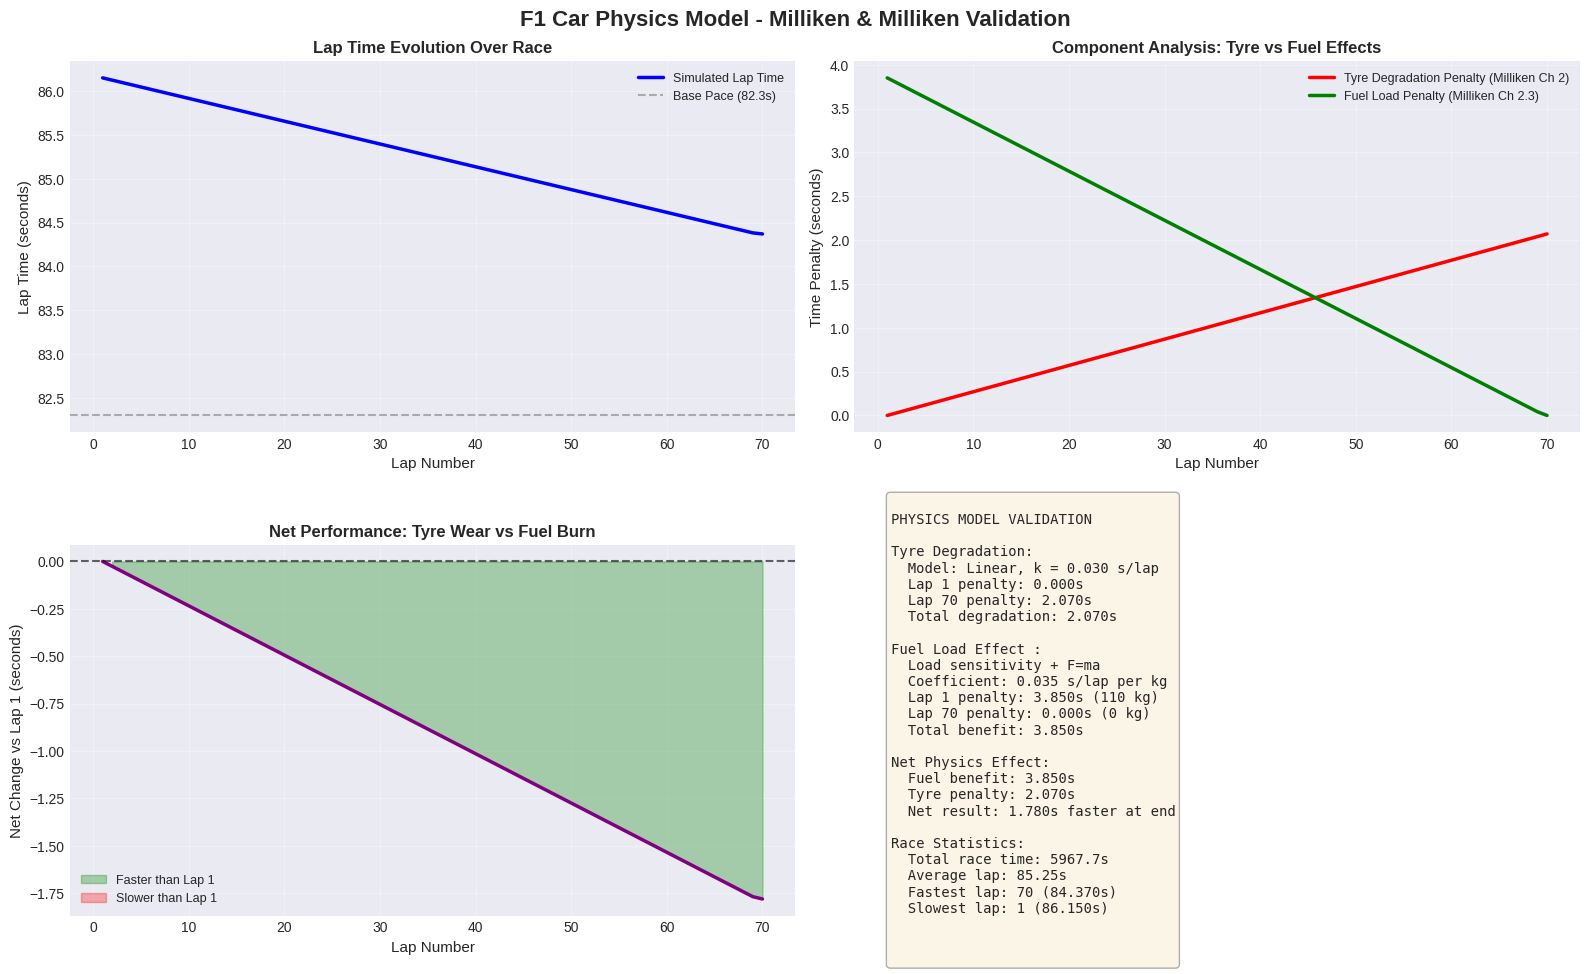

In [4]:
# Create visualization showing Tyre degradation vs fuel burn competition

# Prepare data arrays
laps = np.arange(1, 71)  # Lap numbers 1-70
lap_times = np.array(piastri.lap_times)  # Actual simulated lap times

# Calculate theoretical components for visualization
Tyre_effects = np.arange(70) * 0.030  # Tyre penalty each lap (0, 0.03, 0.06, ...)
fuel_loads = 110.0 - (1.6 * np.arange(70))  # Fuel remaining each lap
fuel_loads = np.maximum(fuel_loads, 0)  # Can't be negative
fuel_effects = fuel_loads * 0.035  # Fuel penalty each lap

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('F1 Car Physics Model - Milliken & Milliken Validation',
             fontsize=16, fontweight='bold')

# Plot 1: Lap Time Evolution
ax1 = axes[0, 0]
ax1.plot(laps, lap_times, 'b-', linewidth=2.5, label='Simulated Lap Time')
ax1.axhline(y=piastri.base_pace, color='gray', linestyle='--',
            alpha=0.6, label=f'Base Pace ({piastri.base_pace}s)')
ax1.set_xlabel('Lap Number', fontsize=11)
ax1.set_ylabel('Lap Time (seconds)', fontsize=11)
ax1.set_title('Lap Time Evolution Over Race', fontsize=12, fontweight='bold')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Individual Physics Effects
ax2 = axes[0, 1]
ax2.plot(laps, Tyre_effects, 'r-', linewidth=2.5,
         label='Tyre Degradation Penalty (Milliken Ch 2)')
ax2.plot(laps, fuel_effects, 'g-', linewidth=2.5,
         label='Fuel Load Penalty (Milliken Ch 2.3)')
ax2.set_xlabel('Lap Number', fontsize=11)
ax2.set_ylabel('Time Penalty (seconds)', fontsize=11)
ax2.set_title('Component Analysis: Tyre vs Fuel Effects',
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Net Performance Change vs Lap 1
ax3 = axes[1, 0]
# Net change = Tyre penalty increase - fuel benefit increase
net_effects = Tyre_effects - (fuel_effects[0] - fuel_effects)
ax3.plot(laps, net_effects, color='purple', linewidth=2.5)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.6)
ax3.fill_between(laps, 0, net_effects,
                  where=(net_effects < 0),
                  alpha=0.3, color='green',
                  label='Faster than Lap 1')
ax3.fill_between(laps, 0, net_effects,
                  where=(net_effects >= 0),
                  alpha=0.3, color='red',
                  label='Slower than Lap 1')
ax3.set_xlabel('Lap Number', fontsize=11)
ax3.set_ylabel('Net Change vs Lap 1 (seconds)', fontsize=11)
ax3.set_title('Net Performance: Tyre Wear vs Fuel Burn',
              fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Key Statistics (text summary)
ax4 = axes[1, 1]
ax4.axis('off')


validation_text = f"""
PHYSICS MODEL VALIDATION

Tyre Degradation:
  Model: Linear, k = 0.030 s/lap
  Lap 1 penalty: {Tyre_effects[0]:.3f}s
  Lap 70 penalty: {Tyre_effects[-1]:.3f}s
  Total degradation: {Tyre_effects[-1]:.3f}s

Fuel Load Effect :
  Load sensitivity + F=ma
  Coefficient: 0.035 s/lap per kg
  Lap 1 penalty: {fuel_effects[0]:.3f}s (110 kg)
  Lap 70 penalty: {fuel_effects[-1]:.3f}s (0 kg)
  Total benefit: {fuel_effects[0]:.3f}s

Net Physics Effect:
  Fuel benefit: {fuel_effects[0]:.3f}s
  Tyre penalty: {Tyre_effects[-1]:.3f}s
  Net result: {fuel_effects[0] - Tyre_effects[-1]:.3f}s faster at end

Race Statistics:
  Total race time: {piastri.total_time:.1f}s
  Average lap: {piastri.total_time/70:.2f}s
  Fastest lap: {fastest_idx + 1} ({piastri.lap_times[fastest_idx]:.3f}s)
  Slowest lap: {np.argmax(piastri.lap_times) + 1} ({max(piastri.lap_times):.3f}s)


"""

ax4.text(0.05, 0.5, validation_text,
         fontsize=10, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()


---

## Summary: Notebook 01

### What Was Built
- `Car` class with physics-based lap time simulation
- Linear tyre degradation model
- Fuel load effect model

### Key Findings
- Fuel burn (~1.6 kg/lap) initially outpaces tyre degradation
- Crossover occurs mid-race when tyre age penalty exceeds fuel benefit
- Fastest lap typically occurs between laps 30-50 (depends on compound)

### Next Steps
**Notebook 02** adds multi-car racing with:
- Position tracking
- Dirty air effects
- Pit stop logic
- Inter-car gap calculations

---

